In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline  
from IPython.display import display, HTML

In [43]:
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score, precision_score, recall_score
import pandas
import numpy as np
import json
import matplotlib.pyplot as plt
import os
import ast
import seaborn
from db import Result
import math
import papermill as pm
from vis.utils.utils import load_img

from config import config
pandas.options.display.float_format = '{:,.3f}'.format

In [3]:
from evaluate import load, get_results, get_labels, transform_binary_probabilities, transform_binary_predictions, calculate_accuracy_loss, plot_confusion_matrix, plot_precision_recall, plot_roc_curve, calculate_pr_auc, calculate_confusion_matrix_stats, calculate_confusion_matrix, plot_tsne, accession_from_filename, plot_expert_confusion, plot_grad_cam, load_expert_results

Using TensorFlow backend.


In [4]:
from data import describe, all_features, data, print_describe, load_single
from run import characterize_data

# All models

In [6]:
CROPS = ["free", "fixed"]
SUBSETS = ["complete", "uncertain"]
DESCRIPTIONS = {
    ("free", "complete"): "complete-set-free-final-2",
    ("fixed", "complete"): "complete-set-fixed-final-2",
    ("free", "uncertain"): "c3-c4-free-final-2",
    ("fixed", "uncertain"): "c3-c4-fixed-final-2",
}
DATA_FOLDERS = {
    ("free", "complete"): "complete-set-free/data",
    ("fixed", "complete"): "complete-set-fixed/data",
    ("free", "uncertain"): "c3-c4-free/data",
    ("fixed", "uncertain"): "c3-c4-fixed/data",
}

In [7]:
for crop in CROPS: 
    for subset in SUBSETS:
        results = Result.query.filter(Result.description == DESCRIPTIONS[(crop, subset)]).all()
        pd = pandas.DataFrame([{
            "accuracy": r.accuracy, 
            "train_accuracy": r.train_accuracy, 
            "uuid": r.uuid
        } for r in results])
        #print(crop, subset)
        #print(pd.nlargest(10, "accuracy"))

In [8]:
UUIDS = {
    ("free", "complete"): "3f408cc9-5eef-414e-8cd7-041fabd9297a",
    ("free", "uncertain"): "21bb651c-c16f-4cba-93d2-ad846ae10c4e",
    ("fixed", "complete"): "08d46f34-4836-4e7c-a240-a0a1c4233093",
    ("fixed", "uncertain"): "f38c310c-d46f-4136-89d8-2a39261c0e0e",
}

In [34]:
PROBABILITIES = dict()
DATASETS = dict()
STATS = dict()
EXPERT1_STATS = dict()
EXPERT2_STATS = dict()
ALL = dict()
RESULT = dict()
CORRECT_INCORRECT = dict()
for crop in CROPS: 
    for subset in SUBSETS:
        display(HTML("<h4>{}-{}</h4>".format(crop, subset)))
        result = Result.query.filter(Result.uuid == UUIDS[(crop, subset)]).first()
        dataset = load_single("{}/validation".format(DATA_FOLDERS[(crop, subset)]))
        probabilities = np.array(ast.literal_eval(result.probabilities))
        predictions = transform_binary_predictions(probabilities)
        stats = calculate_confusion_matrix_stats(get_labels(dataset), probabilities)
        expert1_results = load_expert_results("evaluations/radiology-9809.json", dataset)
        expert2_results = load_expert_results("evaluations/radiology-9809.json", dataset)
        expert1_stats = calculate_confusion_matrix_stats(get_labels(dataset), expert1_results)
        expert2_stats = calculate_confusion_matrix_stats(get_labels(dataset), expert2_results)
        malignancy, modality, category = all_features(features="{}/features.csv".format(DATA_FOLDERS[(crop, subset)]))
        category_labels = [category.get(accession_from_filename(f), f) for f in dataset.filenames]
        RESULT[(crop, subset)] = result
        ALL[(crop, subset)] = pandas.DataFrame({
            "code_abdomen": category_labels,
            "probabilities": probabilities, 
            "expert1": expert1_results, 
            "expert2": expert2_results,
            "labels": get_labels(dataset),
        }) 
        CORRECT_INCORRECT[(crop, subset)] = { dataset.filenames[i]: (dataset.classes[i], predictions[i]) for i, _ in enumerate(dataset.filenames) }
        DATASETS[(crop, subset)] = dataset
        PROBABILITIES[(crop, subset)] = probabilities
        STATS[(crop, subset)] = stats
        EXPERT1_STATS[(crop, subset)] = expert1_stats
        EXPERT2_STATS[(crop, subset)] = expert2_stats
        display(HTML(pandas.DataFrame.from_dict({
            "model": pandas.DataFrame(stats).iloc[1],
            "expert 1": pandas.DataFrame(expert1_stats).iloc[1],
            "expert 2": pandas.DataFrame(expert2_stats).iloc[1],
        }, orient="index").to_html()))

Found 102 images belonging to 2 classes.
error with benign/free-27244981-liver.jpeg: '27244981-liver.jpeg'
error with benign/free-27244981-liver.jpeg: '27244981-liver.jpeg'


,Acc,TP,TN,FP,FN,TPR,TNR,PPV,NPV,FPR,FNR,FDR,AM,GM
expert 1,0.775,20.000,59.000,15.000,8.000,0.714,0.797,0.571,0.881,0.203,0.286,0.429,0.756,0.755
expert 2,0.775,20.000,59.000,15.000,8.000,0.714,0.797,0.571,0.881,0.203,0.286,0.429,0.756,0.755
model,0.833,23.000,62.000,12.000,5.000,0.821,0.838,0.657,0.925,0.162,0.179,0.343,0.830,0.830


Found 47 images belonging to 2 classes.
error with benign/free-27741572-liver.jpeg: '27741572-liver.jpeg'
error with benign/free-27741572-liver.jpeg: '27741572-liver.jpeg'


,Acc,TP,TN,FP,FN,TPR,TNR,PPV,NPV,FPR,FNR,FDR,AM,GM
expert 1,0.745,8.000,27.000,8.000,4.000,0.667,0.771,0.500,0.871,0.229,0.333,0.500,0.719,0.717
expert 2,0.745,8.000,27.000,8.000,4.000,0.667,0.771,0.500,0.871,0.229,0.333,0.500,0.719,0.717
model,0.894,8.000,34.000,1.000,4.000,0.667,0.971,0.889,0.895,0.029,0.333,0.111,0.819,0.805


Found 104 images belonging to 2 classes.
error with benign/fixed-27244981-liver.jpeg: '27244981-liver.jpeg'
error with benign/fixed-27244981-liver.jpeg: '27244981-liver.jpeg'


,Acc,TP,TN,FP,FN,TPR,TNR,PPV,NPV,FPR,FNR,FDR,AM,GM
expert 1,0.625,18.000,47.000,23.000,16.000,0.529,0.671,0.439,0.746,0.329,0.471,0.561,0.600,0.596
expert 2,0.625,18.000,47.000,23.000,16.000,0.529,0.671,0.439,0.746,0.329,0.471,0.561,0.600,0.596
model,0.721,6.000,69.000,1.000,28.000,0.176,0.986,0.857,0.711,0.014,0.824,0.143,0.581,0.417


Found 48 images belonging to 2 classes.


,Acc,TP,TN,FP,FN,TPR,TNR,PPV,NPV,FPR,FNR,FDR,AM,GM
expert 1,0.708,9.000,25.000,10.000,4.000,0.692,0.714,0.474,0.862,0.286,0.308,0.526,0.703,0.703
expert 2,0.708,9.000,25.000,10.000,4.000,0.692,0.714,0.474,0.862,0.286,0.308,0.526,0.703,0.703
model,0.833,6.000,34.000,1.000,7.000,0.462,0.971,0.857,0.829,0.029,0.538,0.143,0.716,0.670


  code  expert1  expert2  model
0   C2    0.933    0.933  0.867
1   C3    0.769    0.769  0.821
2   C4    0.529    0.529  0.882
3   C5    0.750    0.750  0.750


/home/harrison/intrepidlemon/deep-ultrasound/evaluate.py:95: RuntimeWarning: invalid value encountered in true_divide
  TPR = TP/(TP+FN)
/home/harrison/intrepidlemon/deep-ultrasound/evaluate.py:97: RuntimeWarning: invalid value encountered in true_divide
  TNR = TN/(TN+FP)
/home/harrison/intrepidlemon/deep-ultrasound/evaluate.py:103: RuntimeWarning: invalid value encountered in true_divide
  FPR = FP/(FP+TN)
/home/harrison/intrepidlemon/deep-ultrasound/evaluate.py:105: RuntimeWarning: invalid value encountered in true_divide
  FNR = FN/(TP+FN)


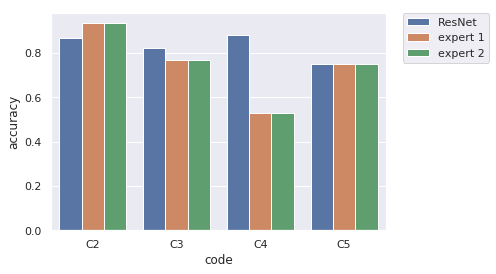

  code  expert1  expert2  model
0   C3    0.758    0.758  0.970
1   C4    0.714    0.714  0.714


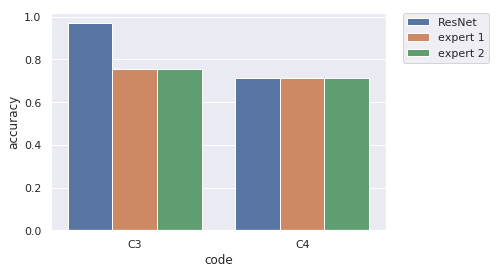

  code  expert1  expert2  model
0   C2    0.743    0.743  0.971
1   C3    0.579    0.579  0.895
2   C4    0.375    0.375  0.375
3   C5    0.609    0.609  0.174


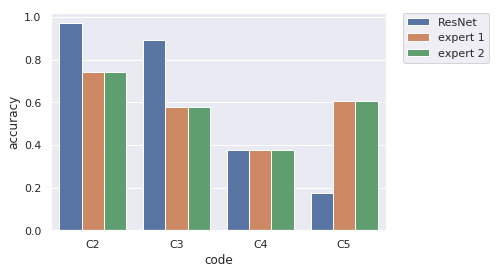

  code  expert1  expert2  model
0   C3    0.686    0.686  0.914
1   C4    0.769    0.769  0.615


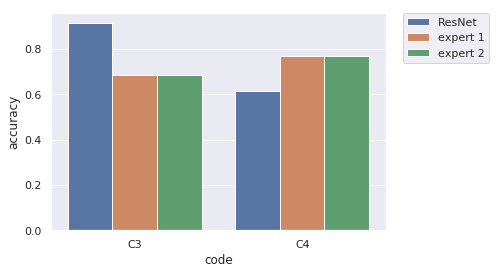

In [10]:
def get_acc(labels, probabilities): 
    stats = calculate_confusion_matrix_stats(labels, probabilities)
    return stats["Acc"][1]

for crop in CROPS: 
    for subset in SUBSETS:
        display(HTML("<h4>{}-{}</h4>".format(crop, subset)))
        results = ALL[(crop, subset)]
        accuracy_by_code = list()
        accuracy_list = list()
        for code in np.unique(results.code_abdomen): 
            pd = results[results.code_abdomen == code]
            model = get_acc(pd["labels"].values, pd["probabilities"].values)
            expert1 = get_acc(pd["labels"].values, pd["expert1"].values)
            expert2 = get_acc(pd["labels"].values, pd["expert2"].values)
            accuracy_list.append({
                "code": code, 
                "model": "ResNet", 
                "accuracy": model, 
            })
            accuracy_list.append({
                "code": code, 
                "model": "expert 1", 
                "accuracy": expert1, 
            })
            accuracy_list.append({
                "code": code, 
                "model": "expert 2", 
                "accuracy": expert2, 
            })                
            accuracy_by_code.append({
                "code": code, 
                "model": model, 
                "expert1": expert1, 
                "expert2": expert2,
            })
        print(pandas.DataFrame(accuracy_by_code))
        seaborn.barplot(data=pandas.DataFrame(accuracy_list), x="code", y="accuracy", hue="model")
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.show()

/home/harrison/.local/share/virtualenvs/deep-ultrasound-k5cplrX3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/harrison/.local/share/virtualenvs/deep-ultrasound-k5cplrX3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


https://cf151f9a.ngrok.io/15265143/liaver.jpeg
https://cf151f9a.ngrok.io/15705324/liver.jpeg
https://cf151f9a.ngrok.io/15764983/liver.jpeg
https://cf151f9a.ngrok.io/15779715/liver.jpeg
https://cf151f9a.ngrok.io/15899132/liver.jpeg
https://cf151f9a.ngrok.io/15987441/liver.jpeg
https://cf151f9a.ngrok.io/15996115/liver.jpeg
https://cf151f9a.ngrok.io/26231700/liver-1.jpeg
https://cf151f9a.ngrok.io/26231700/liver-2.jpeg
https://cf151f9a.ngrok.io/26373027/liver.jpeg
https://cf151f9a.ngrok.io/26424318/liver.jpeg
https://cf151f9a.ngrok.io/26436176/liver.jpeg
https://cf151f9a.ngrok.io/26556456/liver.jpeg
https://cf151f9a.ngrok.io/26852121/liver.jpeg
https://cf151f9a.ngrok.io/27115175/liver-1.jpeg
https://cf151f9a.ngrok.io/27115175/liver-2.jpeg
https://cf151f9a.ngrok.io/27115175/liver-4.jpeg
https://cf151f9a.ngrok.io/27115175/liver.jpeg
https://cf151f9a.ngrok.io/27128001/liver.jpeg
https://cf151f9a.ngrok.io/27164560/liver.jpeg
https://cf151f9a.ngrok.io/27177540/liver-3.jpeg
https://cf151f9a.ngro

https://cf151f9a.ngrok.io/15896690/liver.jpeg
https://cf151f9a.ngrok.io/26227303/liver.jpeg
https://cf151f9a.ngrok.io/26508318/liver.jpeg
https://cf151f9a.ngrok.io/26868773/liver-2.jpeg
https://cf151f9a.ngrok.io/26868773/liver.jpeg
https://cf151f9a.ngrok.io/27075350/liver.jpeg
https://cf151f9a.ngrok.io/27180434/liver.jpeg
https://cf151f9a.ngrok.io/27223029/liver.jpeg
https://cf151f9a.ngrok.io/27411400/liver.jpeg
https://cf151f9a.ngrok.io/27425522/liver.jpeg
https://cf151f9a.ngrok.io/27546260/liver.jpeg
https://cf151f9a.ngrok.io/27574652/liver.jpeg
https://cf151f9a.ngrok.io/27756113/liver.jpeg
https://cf151f9a.ngrok.io/28503426/liver-2.jpeg
https://cf151f9a.ngrok.io/28746483/liver-2.jpeg
https://cf151f9a.ngrok.io/28746483/liver.jpeg
https://cf151f9a.ngrok.io/28901883/liver.jpeg
https://cf151f9a.ngrok.io/29327457/liver-2.jpeg
https://cf151f9a.ngrok.io/29399341/liver.jpeg
https://cf151f9a.ngrok.io/29663415/liver.jpeg
https://cf151f9a.ngrok.io/29987556/liver.jpeg
https://cf151f9a.ngrok.io/

https://cf151f9a.ngrok.io/26124887/liver.jpeg
https://cf151f9a.ngrok.io/26355585/liver.jpeg
https://cf151f9a.ngrok.io/26453970/liver.jpeg
https://cf151f9a.ngrok.io/26713257/liver.jpeg
https://cf151f9a.ngrok.io/27115175/liver-3.jpeg
https://cf151f9a.ngrok.io/27177540/liver-2.jpeg
https://cf151f9a.ngrok.io/28188798/liver.jpeg
https://cf151f9a.ngrok.io/28383202/liver.jpeg
https://cf151f9a.ngrok.io/28534547/liver.jpeg
https://cf151f9a.ngrok.io/28705641/liver.jpeg
https://cf151f9a.ngrok.io/28831263/liver.jpeg
https://cf151f9a.ngrok.io/29397826/liver.jpeg


https://cf151f9a.ngrok.io/26269612/liver.jpeg
https://cf151f9a.ngrok.io/26603779/liver.jpeg
https://cf151f9a.ngrok.io/27345619/liver.jpeg
https://cf151f9a.ngrok.io/29327457/liver.jpeg
https://cf151f9a.ngrok.io/29929975/liver.jpeg


https://cf151f9a.ngrok.io/15551563/liver-2.jpeg
https://cf151f9a.ngrok.io/15987441/liver.jpeg
https://cf151f9a.ngrok.io/26114650/liver.jpeg
https://cf151f9a.ngrok.io/26788792/liver.jpeg
https://cf151f9a.ngrok.io/27073745/liver-2.jpeg
https://cf151f9a.ngrok.io/27073745/liver.jpeg
https://cf151f9a.ngrok.io/27247600/liver.jpeg
https://cf151f9a.ngrok.io/27257835/liver.jpeg
https://cf151f9a.ngrok.io/27369141/liver-2.jpeg
https://cf151f9a.ngrok.io/27369141/liver-3.jpeg
https://cf151f9a.ngrok.io/27369141/liver.jpeg
https://cf151f9a.ngrok.io/27403964/liver-2.jpeg
https://cf151f9a.ngrok.io/27403964/liver.jpeg
https://cf151f9a.ngrok.io/27604977/liver.jpeg
https://cf151f9a.ngrok.io/27741572/liver.jpeg
https://cf151f9a.ngrok.io/27977474/liver.jpeg
https://cf151f9a.ngrok.io/28006871/liver-2.jpeg
https://cf151f9a.ngrok.io/28006871/liver.jpeg
https://cf151f9a.ngrok.io/28129989/liver-2.jpeg
https://cf151f9a.ngrok.io/28129989/liver-3.jpeg
https://cf151f9a.ngrok.io/28129989/liver.jpeg
https://cf151f9a.n

https://cf151f9a.ngrok.io/15582426/liver.jpeg
https://cf151f9a.ngrok.io/26428183/liver-2.jpeg
https://cf151f9a.ngrok.io/26428183/liver.jpeg
https://cf151f9a.ngrok.io/27574652/liver.jpeg
https://cf151f9a.ngrok.io/28610471/liver.jpeg
https://cf151f9a.ngrok.io/28985749/liver-2.jpeg
https://cf151f9a.ngrok.io/28985749/liver.jpeg
https://cf151f9a.ngrok.io/29088638/liver.jpeg


https://cf151f9a.ngrok.io/15551563/liver.jpeg


https://cf151f9a.ngrok.io/26227303/liver.jpeg
https://cf151f9a.ngrok.io/27180434/liver.jpeg
https://cf151f9a.ngrok.io/27625401/liver.jpeg
https://cf151f9a.ngrok.io/27959725/liver.jpeg


https://cf151f9a.ngrok.io/15478991/liver.jpeg
https://cf151f9a.ngrok.io/15573577/liver.jpeg
https://cf151f9a.ngrok.io/15579240/liver.jpeg
https://cf151f9a.ngrok.io/15754818/liver-1.jpeg
https://cf151f9a.ngrok.io/15957948/liver.jpeg
https://cf151f9a.ngrok.io/15987441/liver.jpeg
https://cf151f9a.ngrok.io/26002248/liver.jpeg
https://cf151f9a.ngrok.io/26051811/liver-1.jpeg
https://cf151f9a.ngrok.io/26051811/liver.jpeg
https://cf151f9a.ngrok.io/26168667/liver.jpeg
https://cf151f9a.ngrok.io/26183842/liver.jpeg
https://cf151f9a.ngrok.io/26213342/liver-1.jpeg
https://cf151f9a.ngrok.io/26213342/liver-2.jpeg
https://cf151f9a.ngrok.io/26255625/liver.jpeg
https://cf151f9a.ngrok.io/26401332/liver.jpeg
https://cf151f9a.ngrok.io/26420409/liver.jpeg
https://cf151f9a.ngrok.io/26424962/liver.jpeg
https://cf151f9a.ngrok.io/26436176/liver.jpeg
https://cf151f9a.ngrok.io/26616867/liver.jpeg
https://cf151f9a.ngrok.io/26765562/liver.jpeg
https://cf151f9a.ngrok.io/26864409/liver.jpeg
https://cf151f9a.ngrok.io/

https://cf151f9a.ngrok.io/26115783/liver.jpeg
https://cf151f9a.ngrok.io/26758017/liver.jpeg
https://cf151f9a.ngrok.io/27411400/liver.jpeg
https://cf151f9a.ngrok.io/28357978/liver-3.jpeg
https://cf151f9a.ngrok.io/28646314/liver.jpeg
https://cf151f9a.ngrok.io/30019459/liver.jpeg


https://cf151f9a.ngrok.io/28878239/liver.jpeg


https://cf151f9a.ngrok.io/15488160/liver.jpeg
https://cf151f9a.ngrok.io/15909347/liver.jpeg
https://cf151f9a.ngrok.io/26115783/liver-2.jpeg
https://cf151f9a.ngrok.io/26588978/liver.jpeg
https://cf151f9a.ngrok.io/26758017/liver-2.jpeg
https://cf151f9a.ngrok.io/26864712/liver.jpeg
https://cf151f9a.ngrok.io/26868773/liver-2.jpeg
https://cf151f9a.ngrok.io/26868773/liver.jpeg
https://cf151f9a.ngrok.io/27293940/liver.jpeg
https://cf151f9a.ngrok.io/27735290/liver.jpeg
https://cf151f9a.ngrok.io/27959725/liver.jpeg
https://cf151f9a.ngrok.io/28246550/liver.jpeg
https://cf151f9a.ngrok.io/28357978/liver-2.jpeg
https://cf151f9a.ngrok.io/28357978/liver-4.jpeg
https://cf151f9a.ngrok.io/28357978/liver.jpeg
https://cf151f9a.ngrok.io/28445913/liver.jpeg
https://cf151f9a.ngrok.io/28610471/liver.jpeg
https://cf151f9a.ngrok.io/28664237/liver.jpeg
https://cf151f9a.ngrok.io/28746483/liver-2.jpeg
https://cf151f9a.ngrok.io/28746483/liver.jpeg
https://cf151f9a.ngrok.io/29086364/liver-2.jpeg
https://cf151f9a.ngr

https://cf151f9a.ngrok.io/15889706/liver.jpeg
https://cf151f9a.ngrok.io/15987441/liver.jpeg
https://cf151f9a.ngrok.io/26231700/liver-1.jpeg
https://cf151f9a.ngrok.io/26231700/liver-2.jpeg
https://cf151f9a.ngrok.io/26252663/liver-1.jpeg
https://cf151f9a.ngrok.io/26438501/liver-1.jpeg
https://cf151f9a.ngrok.io/26438501/liver-2.jpeg
https://cf151f9a.ngrok.io/26438501/liver-3.jpeg
https://cf151f9a.ngrok.io/26438501/liver-4.jpeg
https://cf151f9a.ngrok.io/26438501/liver-5.jpeg
https://cf151f9a.ngrok.io/26438501/liver-6.jpeg
https://cf151f9a.ngrok.io/26453970/liver.jpeg
https://cf151f9a.ngrok.io/26616867/liver.jpeg
https://cf151f9a.ngrok.io/26631175/liver.jpeg
https://cf151f9a.ngrok.io/26864409/liver.jpeg
https://cf151f9a.ngrok.io/26894020/liver.jpeg
https://cf151f9a.ngrok.io/27164560/liver.jpeg
https://cf151f9a.ngrok.io/27188709/liver-2.jpeg
https://cf151f9a.ngrok.io/27188709/liver.jpeg
https://cf151f9a.ngrok.io/27371526/liver.jpeg
https://cf151f9a.ngrok.io/27403964/liver-2.jpeg
https://cf15

https://cf151f9a.ngrok.io/26336316/liver.jpeg
https://cf151f9a.ngrok.io/27825433/liver-2.jpeg
https://cf151f9a.ngrok.io/27825433/liver.jpeg
https://cf151f9a.ngrok.io/28746483/liver-2.jpeg
https://cf151f9a.ngrok.io/28985749/liver-2.jpeg
https://cf151f9a.ngrok.io/28985749/liver.jpeg


https://cf151f9a.ngrok.io/27811439/liver.jpeg


https://cf151f9a.ngrok.io/15582426/liver.jpeg
https://cf151f9a.ngrok.io/26508318/liver.jpeg
https://cf151f9a.ngrok.io/26919936/liver.jpeg
https://cf151f9a.ngrok.io/27574652/liver.jpeg
https://cf151f9a.ngrok.io/27959725/liver.jpeg
https://cf151f9a.ngrok.io/28050498/liver.jpeg
https://cf151f9a.ngrok.io/28746483/liver.jpeg


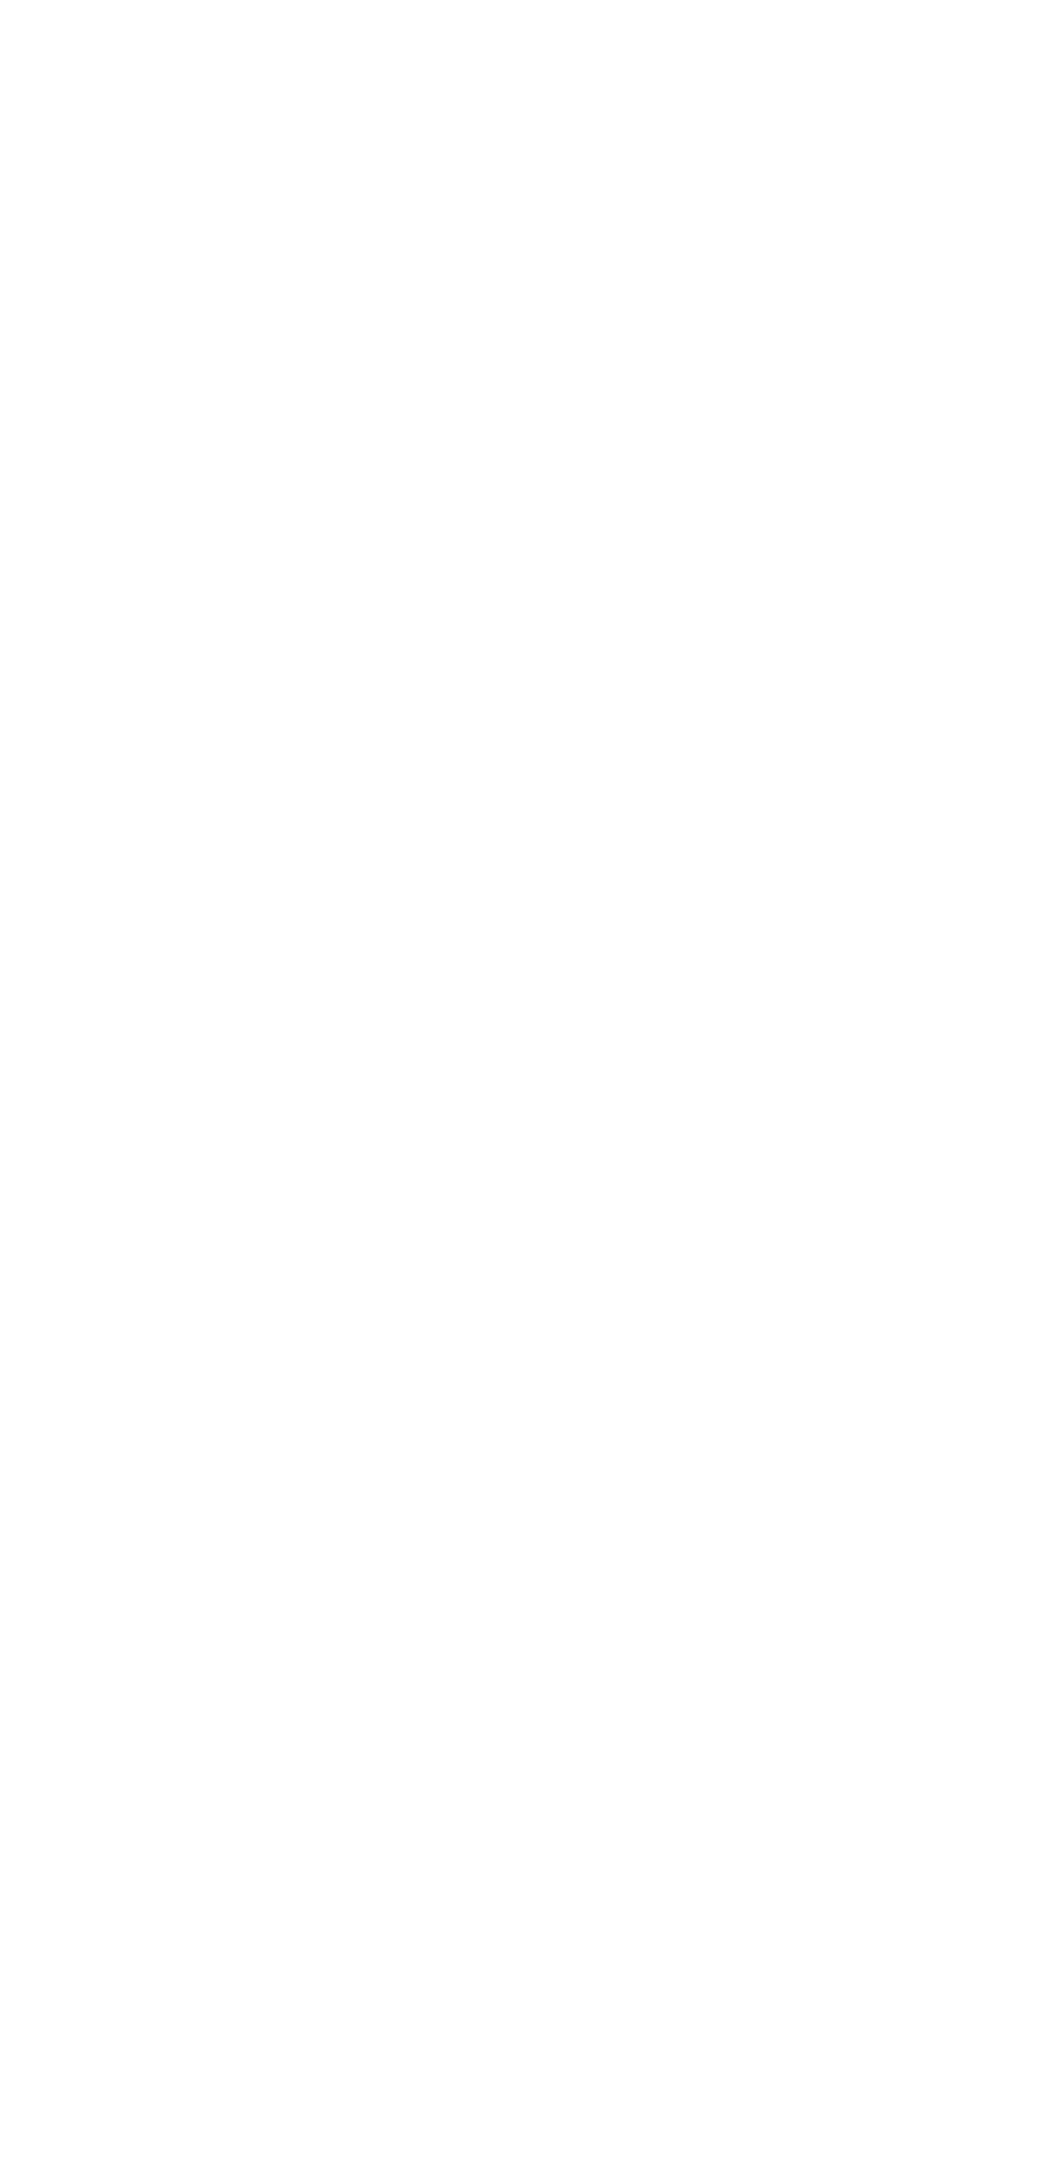

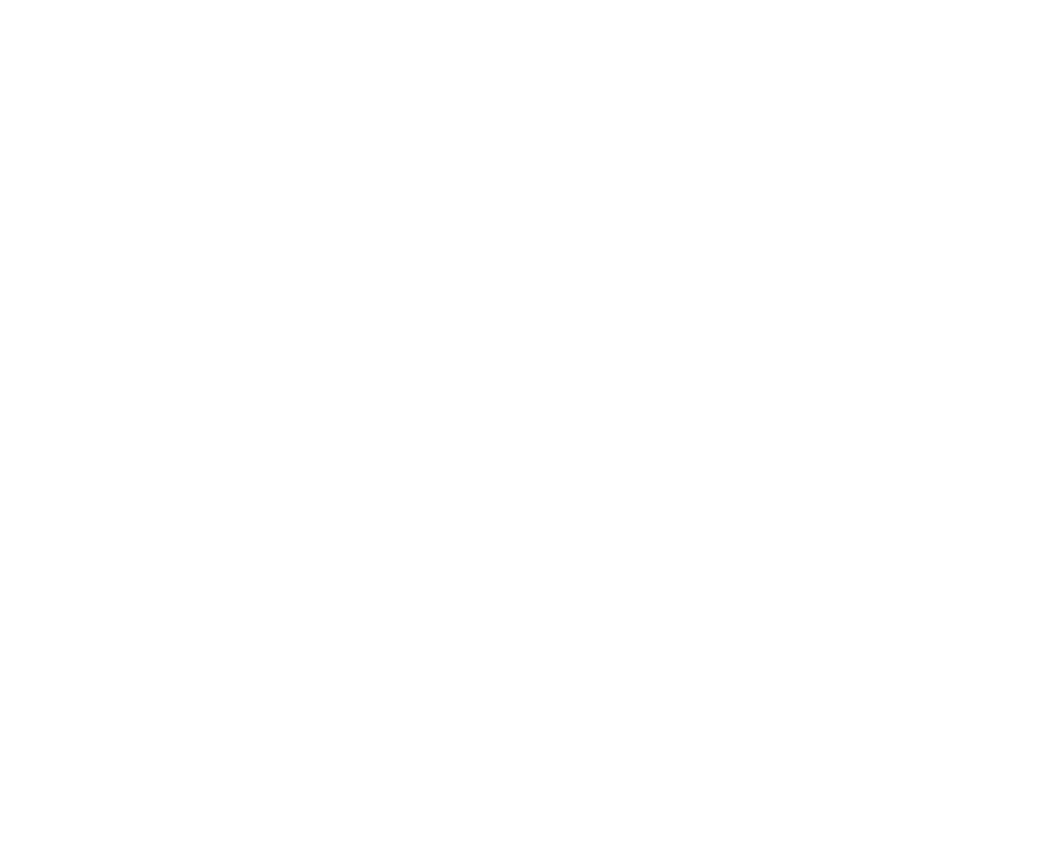

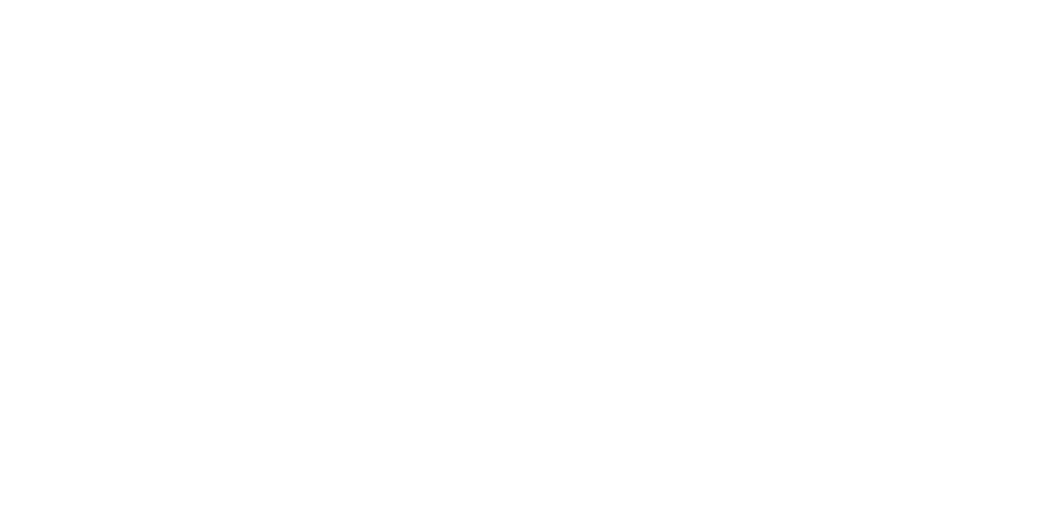

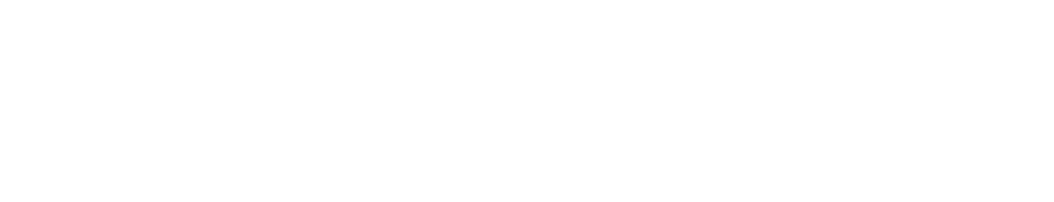

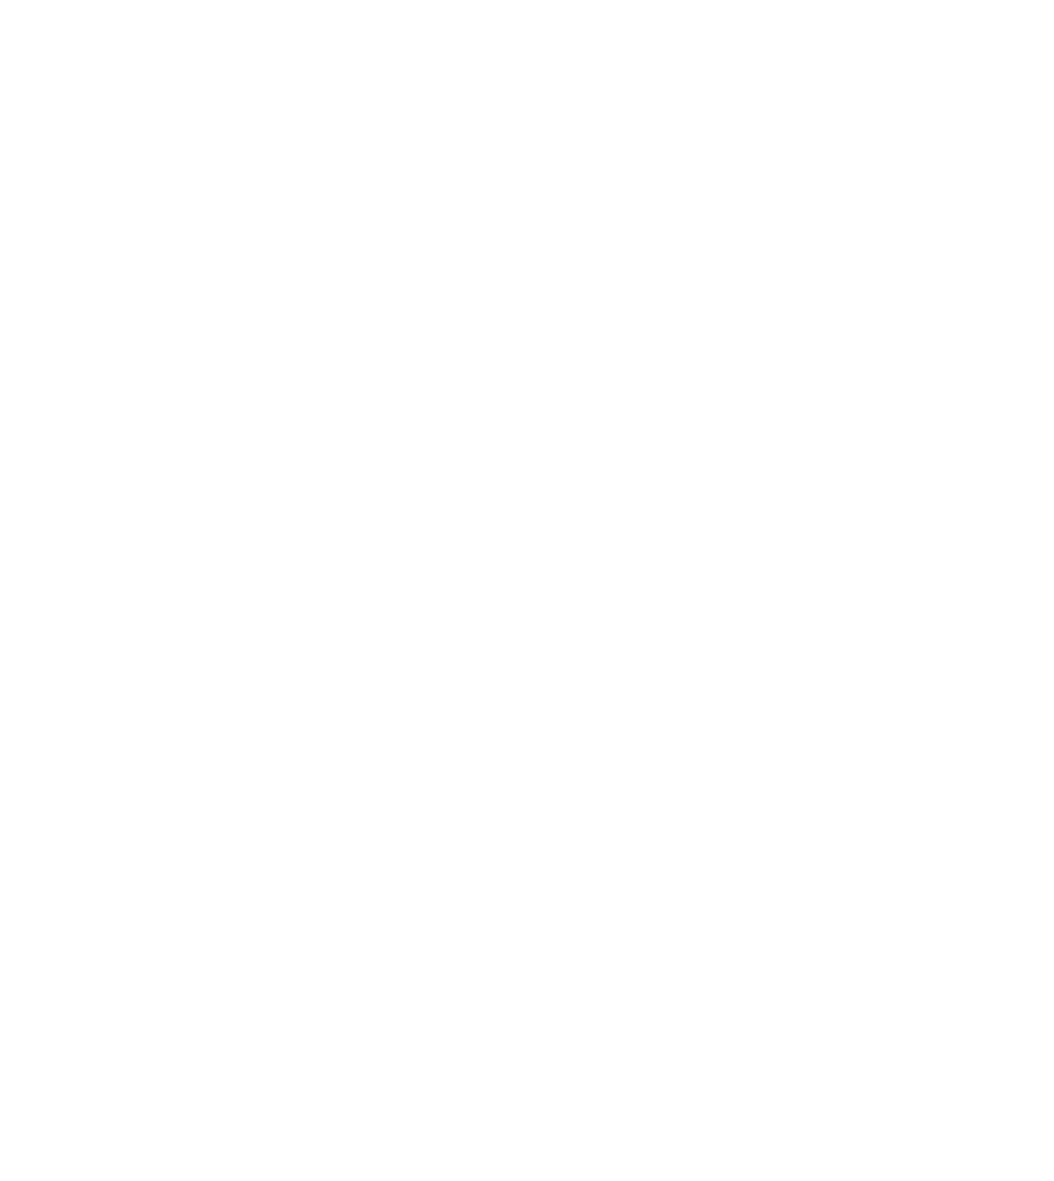

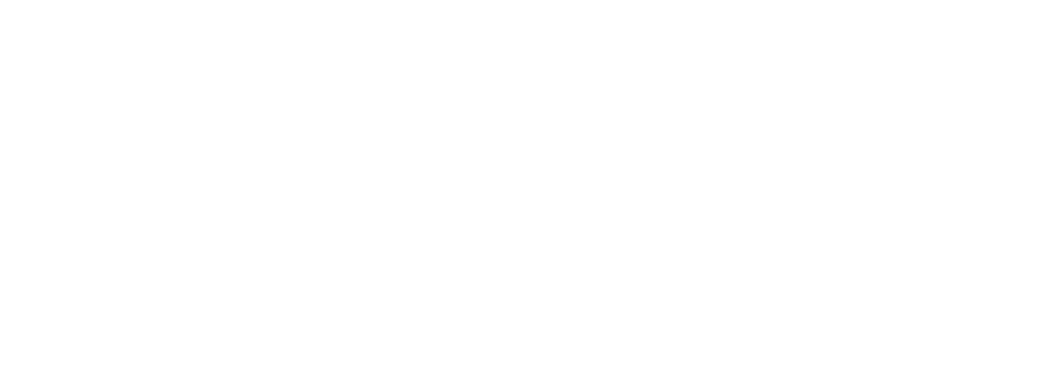

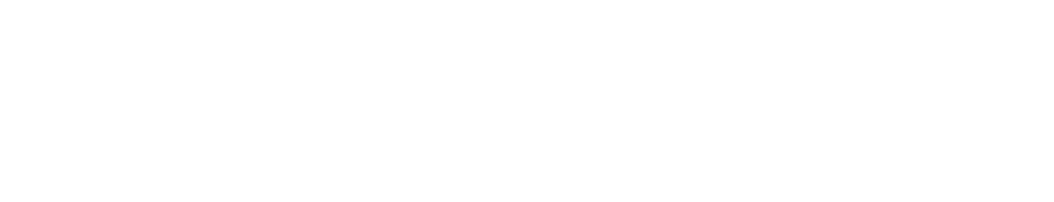

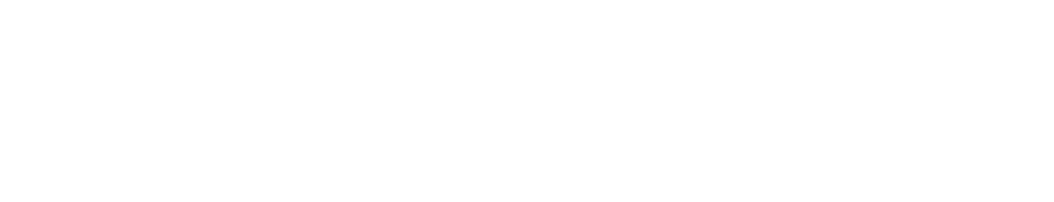

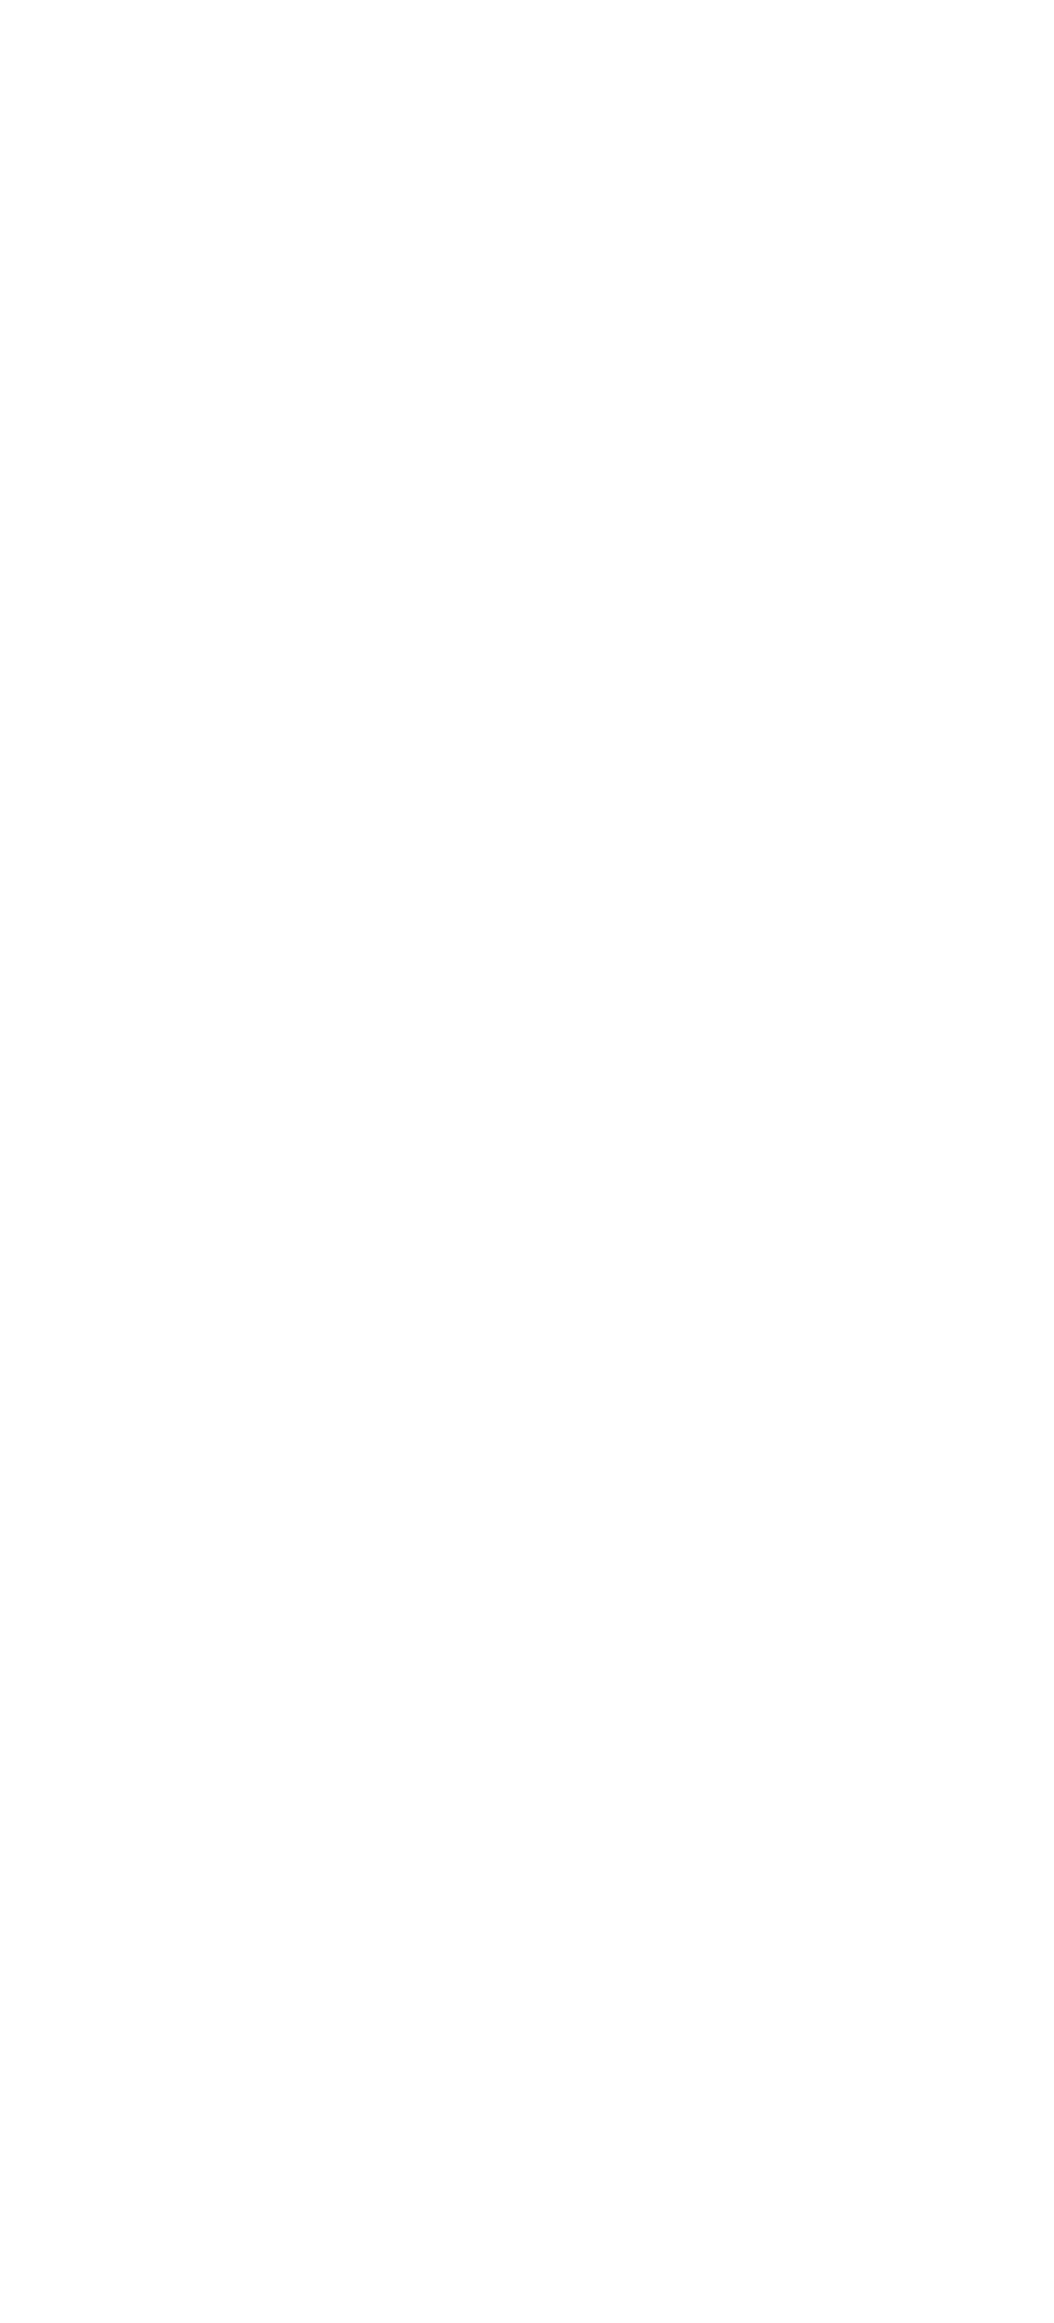

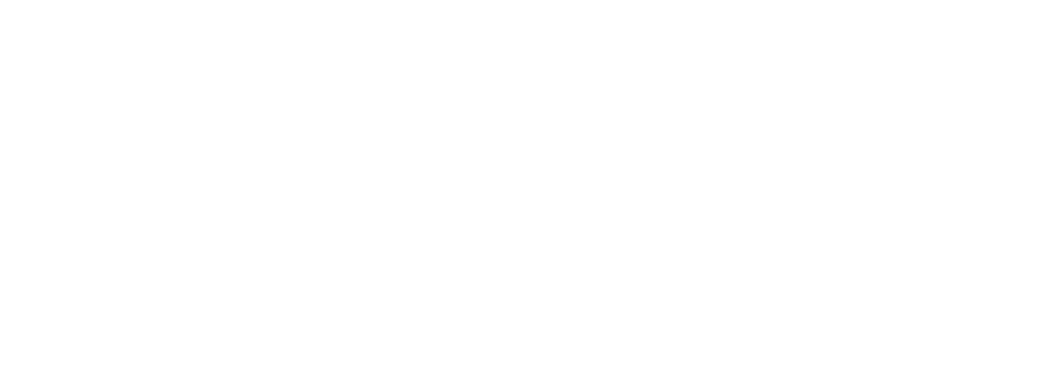

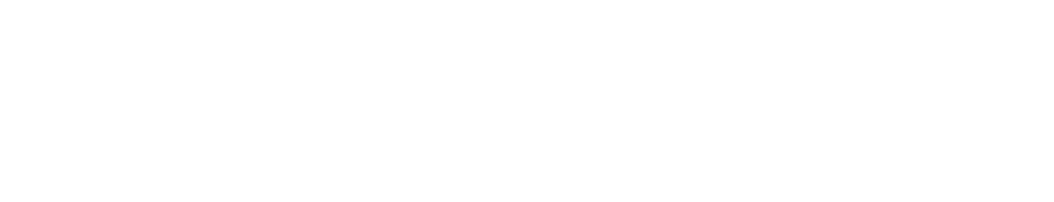

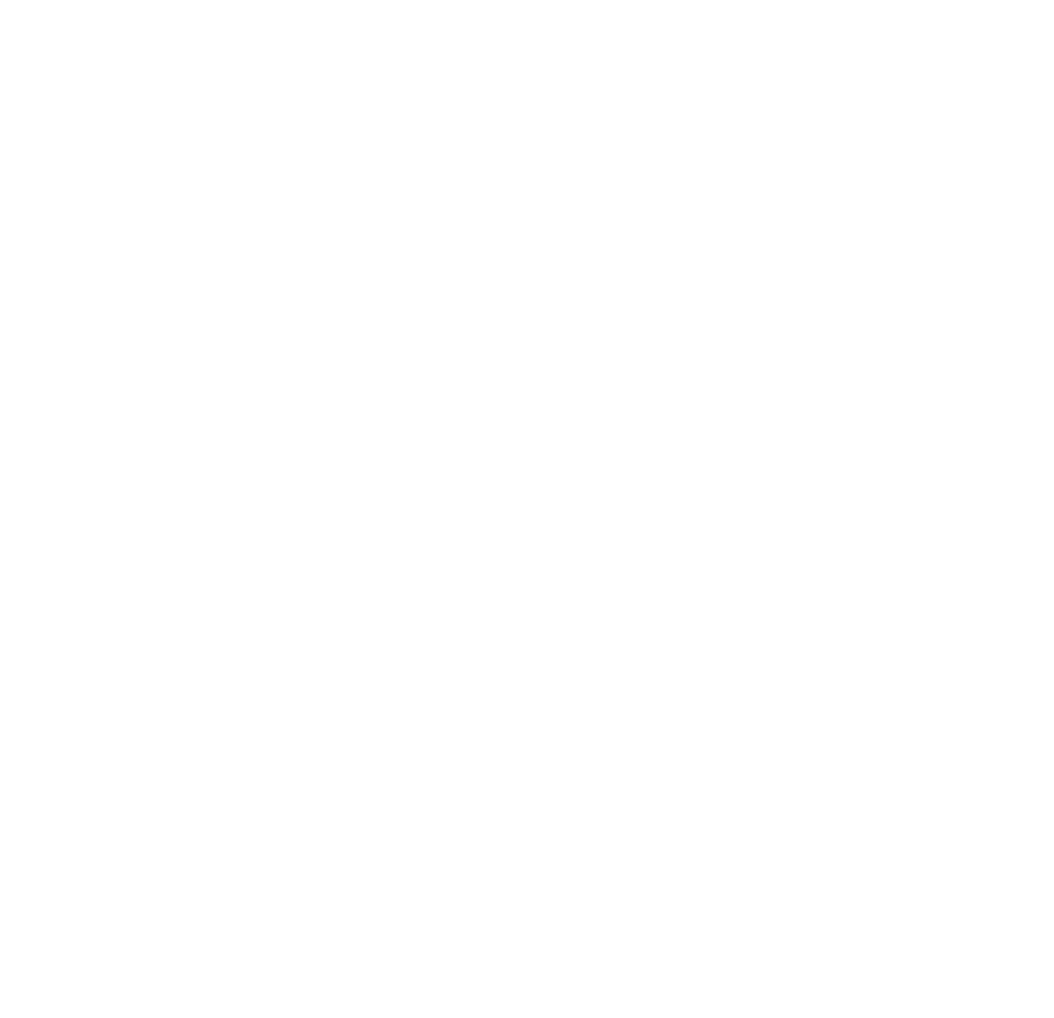

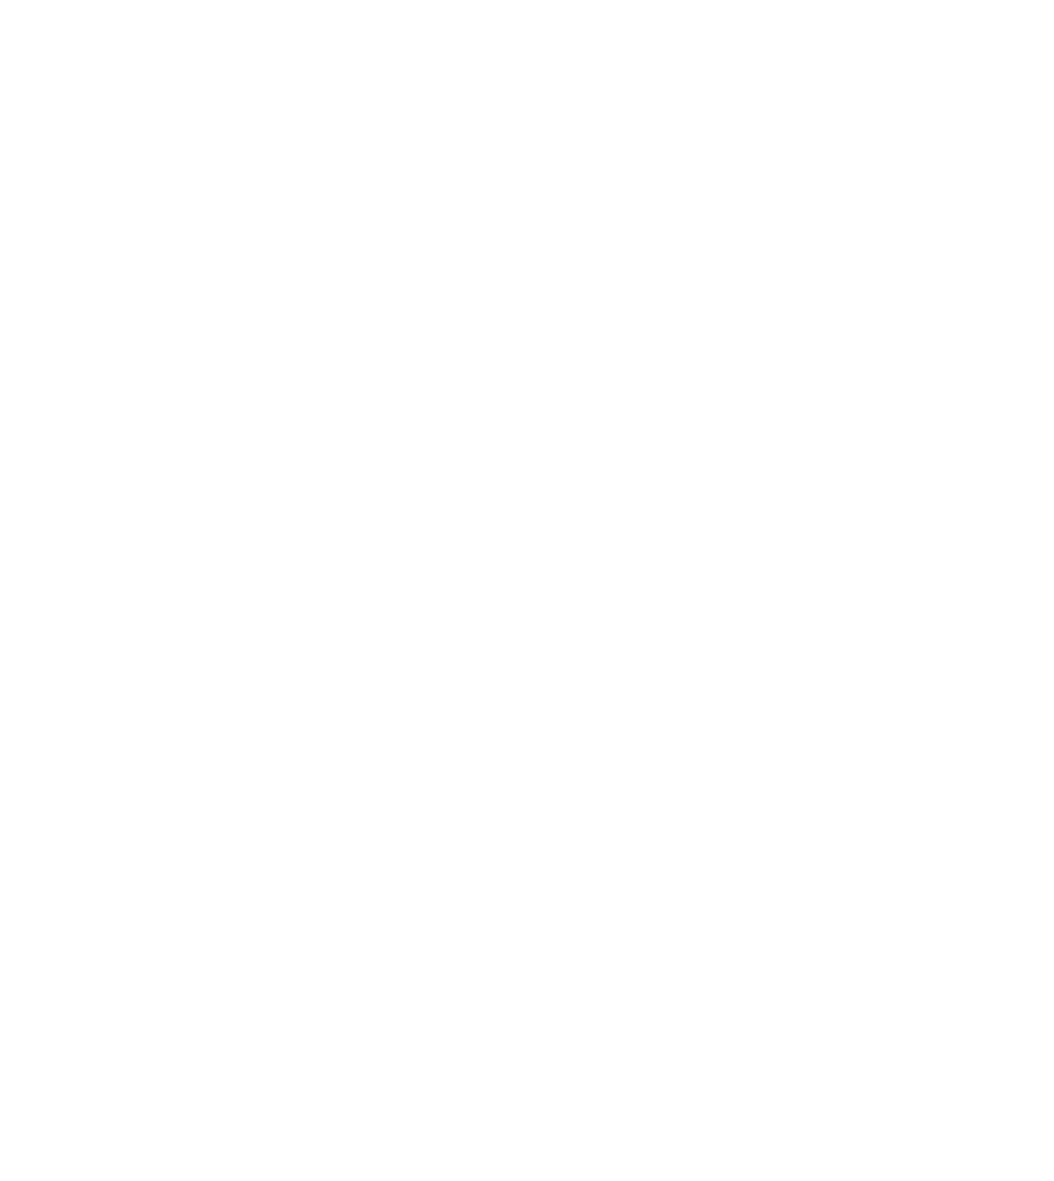

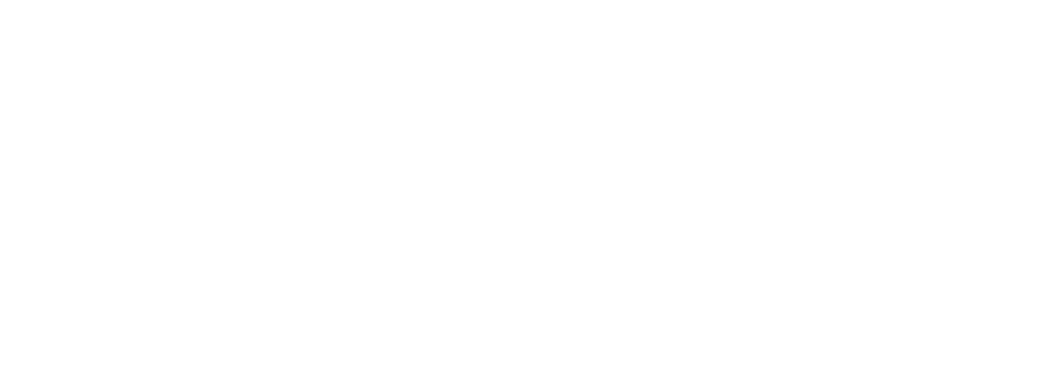

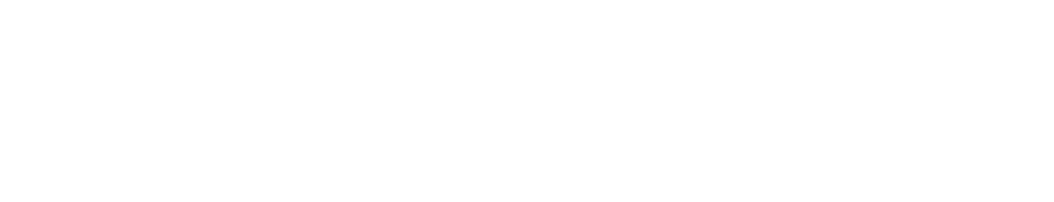

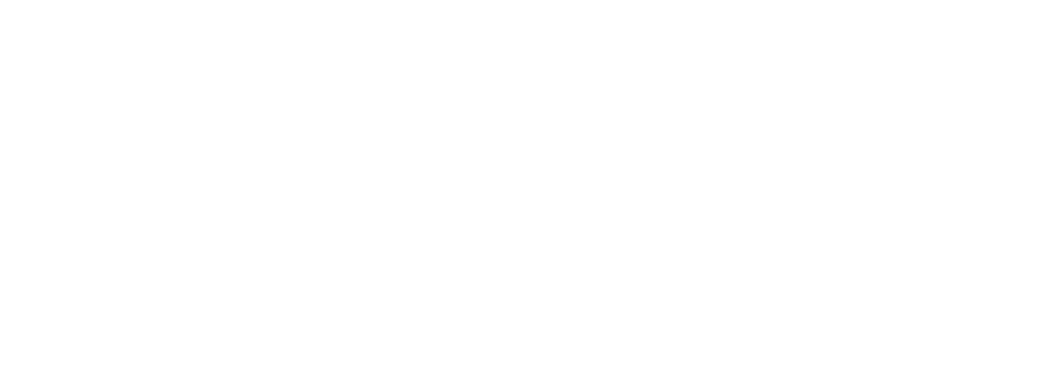

In [61]:
COLUMNS = 5
for crop in CROPS: 
    for subset in SUBSETS:
        display(HTML("<h3>{}-{}</h3>".format(crop, subset)))
        correct_incorrect = CORRECT_INCORRECT[(crop, subset)]
        by_correctness = {
            (0, 0): list(), 
            (1, 1): list(), 
            (0, 1): list(), 
            (1, 0): list(),
        }
        dataset = DATASETS[(crop, subset)]
        inv_indices = {v: k for k, v in dataset.class_indices.items()}
        for k, v in correct_incorrect.items(): 
            by_correctness[v].append(k)
        for k, v in by_correctness.items():
            display(HTML("<h5>diagnosis: {} | prediction: {}</h5>".format(inv_indices[k[0]], inv_indices[k[1]])))
            rows = int(math.ceil(len(v)/COLUMNS))
            f, ax = plt.subplots(rows, COLUMNS, figsize=(18, 3 * rows))
            ax = ax.flatten()
            for i, filename in enumerate(v): 
                image_file = "{}/validation/{}".format(DATA_FOLDERS[(crop, subset)], filename)
                image = load_img(image_file, target_size=(config.IMAGE_SIZE, config.IMAGE_SIZE))
                m = filename.split("-")
                m.pop(0)
                accession = m.pop(0)
                accession = accession.split("/")[0]
                print("https://cf151f9a.ngrok.io/{}/{}".format(accession, "-".join(m)))
            #    ax[i].imshow(image)
            for a in ax: 
                a.axis('off')
            # plt.show()
            

In [27]:
int(36/5)

7

In [16]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

# Evaluate all models

In [15]:
for crop in CROPS: 
    for subset in SUBSETS:
        pm.execute_notebook(
            "evaluate-specific-model.ipynb",
            "evaluate-{}-{}.ipynb".format(crop, subset),
            parameters = dict(
                DIRECTORY = DATA_FOLDERS[(crop, subset)],
                MODEL_UUID = UUIDS[(crop, subset)],
                MODEL_TYPE = RESULT[(crop, subset)].model,
            ),
        )

Input Notebook:  evaluate-specific-model.ipynb
Output Notebook: evaluate-free-complete.ipynb
100%|██████████| 46/46 [00:40<00:00,  1.14it/s]
Input Notebook:  evaluate-specific-model.ipynb
Output Notebook: evaluate-free-uncertain.ipynb
100%|██████████| 46/46 [00:38<00:00,  1.21it/s]
Input Notebook:  evaluate-specific-model.ipynb
Output Notebook: evaluate-fixed-complete.ipynb
100%|██████████| 46/46 [00:40<00:00,  1.13it/s]
Input Notebook:  evaluate-specific-model.ipynb
Output Notebook: evaluate-fixed-uncertain.ipynb
100%|██████████| 46/46 [00:38<00:00,  1.21it/s]
